ICU BED ASSIGNMENT OPTIMIZATION

Generating data...
✓ Created 150 patients and 40 beds

Applying Fuzzy Logic...
✓ Priority range: 5.00 - 85.00

Top 10 Priority Patients:
  1. Patient 20: Priority=85.00, Risk=8, Vital=1
  2. Patient 67: Priority=85.00, Risk=8, Vital=3
  3. Patient 125: Priority=85.00, Risk=8, Vital=5
  4. Patient 9: Priority=80.00, Risk=9, Vital=4
  5. Patient 43: Priority=80.00, Risk=9, Vital=10
  6. Patient 101: Priority=80.00, Risk=9, Vital=5
  7. Patient 114: Priority=80.00, Risk=9, Vital=6
  8. Patient 117: Priority=80.00, Risk=9, Vital=1
  9. Patient 122: Priority=80.00, Risk=9, Vital=6
  10. Patient 18: Priority=75.00, Risk=8, Vital=1

Genetic Algorithm Running...
  Gen 1: Best=3284.73, Avg=3124.37
  Gen 31: Best=3500.55, Avg=3445.26
  Gen 61: Best=3596.41, Avg=3574.29
  Gen 91: Best=3596.41, Avg=3581.96
  Gen 121: Best=3596.41, Avg=3583.55
  Gen 150: Best=3596.41, Avg=3581.61

✓ GA Complete! Best: 3596.41

RESULTS & ANALYSIS

1. BED ASSIGNMENTS (First 15):
 Bed 

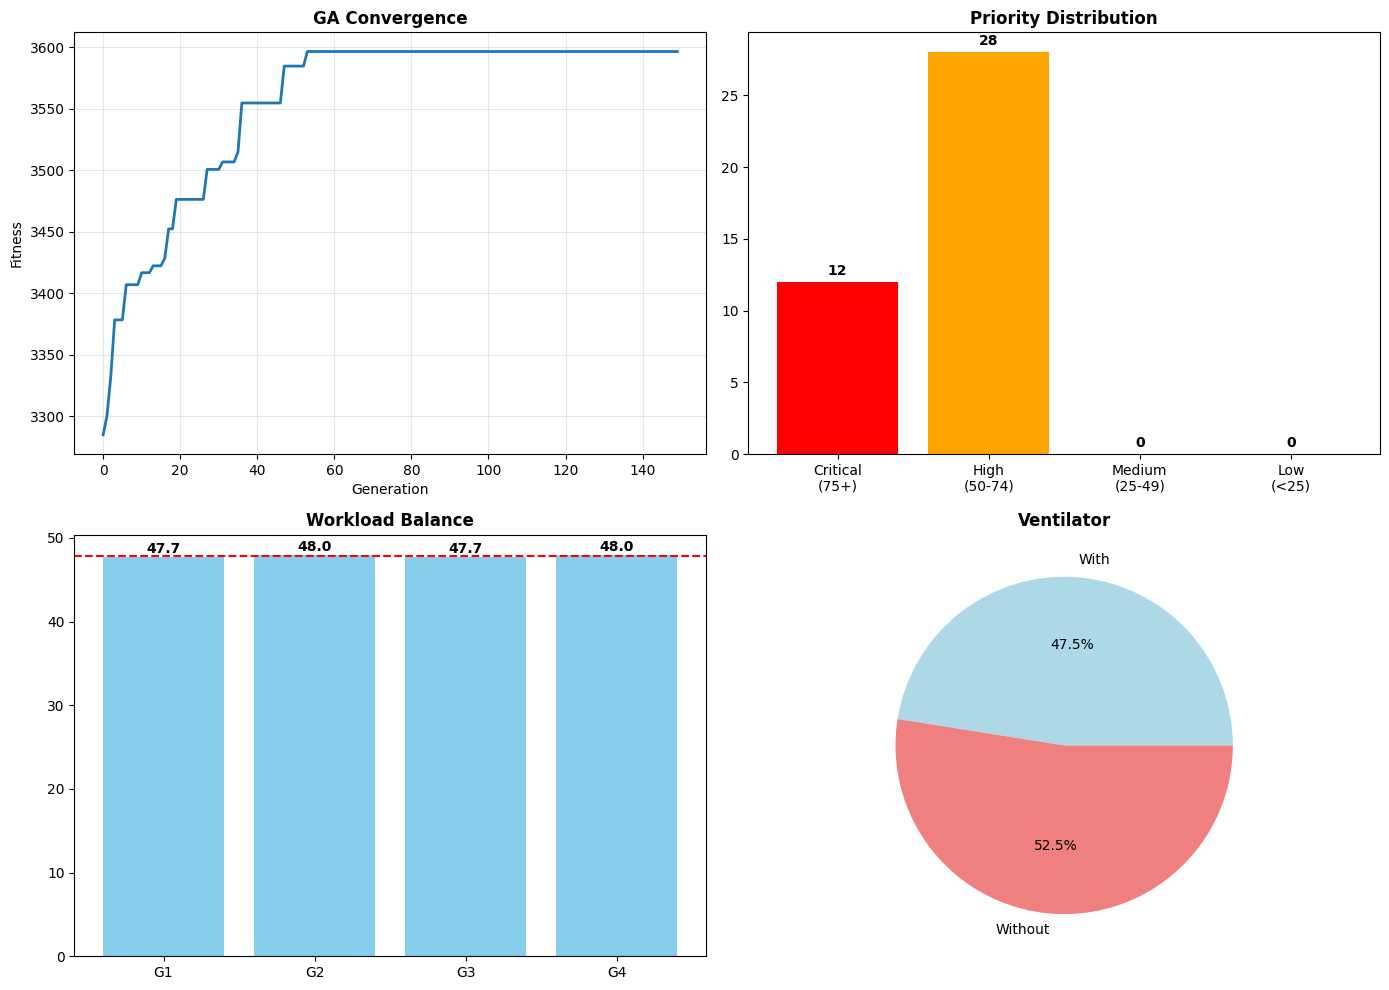

✓ Results saved to 'bed_assignments.csv'

✓ OPTIMIZATION COMPLETE!


In [1]:
# ============================================================================
# ICU BED ASSIGNMENT OPTIMIZATION - STUDENT VERSION
# Cognitive CodeQuest 2025
# ============================================================================

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
random.seed(42)

print("="*80)
print("ICU BED ASSIGNMENT OPTIMIZATION")
print("="*80)

# ============================================================================
# CLASSES
# ============================================================================

class Patient:
    def __init__(self, pid, risk, age, comorb, vital, rec):
        self.id = pid
        self.risk = risk
        self.age = age
        self.comorb = comorb
        self.vital = vital
        self.rec = rec
        self.priority = 0

class Bed:
    def __init__(self, bid, vent, spec, nurse):
        self.id = bid
        self.ventilator = vent
        self.specialty = spec
        self.nurse_group = nurse

# ============================================================================
# FUZZY LOGIC SYSTEM
# ============================================================================

class FuzzyLogic:

    @staticmethod
    def triangular(x, a, b, c):
        """Triangular membership function"""
        if x <= a or x >= c:
            return 0
        elif a < x <= b:
            return (x - a) / (b - a)
        else:
            return (c - x) / (c - b)

    def fuzzify_risk(self, risk):
        low = self.triangular(risk, 0, 2, 4)
        medium = self.triangular(risk, 3, 5, 7)
        high = self.triangular(risk, 6, 8, 10)
        critical = self.triangular(risk, 8, 9, 10)
        return {'low': low, 'medium': medium, 'high': high, 'critical': critical}

    def fuzzify_age(self, age):
        young = self.triangular(age, 18, 30, 50)
        middle = self.triangular(age, 40, 55, 70)
        elderly = self.triangular(age, 60, 75, 90)
        return {'young': young, 'middle': middle, 'elderly': elderly}

    def fuzzify_vital(self, vital):
        stable = self.triangular(vital, 1, 3, 5)
        moderate = self.triangular(vital, 4, 6, 8)
        severe = self.triangular(vital, 7, 8, 10)
        return {'stable': stable, 'moderate': moderate, 'severe': severe}

    def fuzzify_comorb(self, comorb):
        none = 1 if comorb == 0 else 0
        few = self.triangular(comorb, 0, 1.5, 3)
        multiple = self.triangular(comorb, 2, 3.5, 5)
        return {'none': none, 'few': few, 'multiple': multiple}

    def apply_rules(self, risk_f, age_f, vital_f, comorb_f, rec):
        """Apply fuzzy inference rules"""
        scores = []

        if risk_f['critical'] > 0.4 and vital_f['severe'] > 0.4:
            scores.append(95 * min(risk_f['critical'], vital_f['severe']))

        if risk_f['high'] > 0.3 and vital_f['severe'] > 0.3:
            scores.append(85 * min(risk_f['high'], vital_f['severe']))

        if risk_f['critical'] > 0.5:
            scores.append(80 * risk_f['critical'])

        if age_f['elderly'] > 0.4 and comorb_f['multiple'] > 0.3:
            scores.append(75 * min(age_f['elderly'], comorb_f['multiple']))

        if rec > 7:
            scores.append(70 * (rec / 10))

        if risk_f['medium'] > 0.3 and vital_f['moderate'] > 0.3:
            scores.append(50 * min(risk_f['medium'], vital_f['moderate']))

        if comorb_f['multiple'] > 0.4:
            scores.append(60 * comorb_f['multiple'])

        if risk_f['low'] > 0.5 and vital_f['stable'] > 0.5:
            scores.append(30 * min(risk_f['low'], vital_f['stable']))

        if scores:
            return sum(scores) / len(scores)
        else:
            return risk_f['high'] * 50 + vital_f['severe'] * 40 + rec * 5

    def calc_priority(self, p):
        risk_f = self.fuzzify_risk(p.risk)
        age_f = self.fuzzify_age(p.age)
        vital_f = self.fuzzify_vital(p.vital)
        comorb_f = self.fuzzify_comorb(p.comorb)

        priority = self.apply_rules(risk_f, age_f, vital_f, comorb_f, p.rec)
        return min(100, max(0, priority))

# ============================================================================
# GENETIC ALGORITHM
# ============================================================================

class GA:

    def __init__(self, patients, beds, pop=100, gens=150, mut_rt=0.15):
        self.patients = patients[:40]
        self.all = patients
        self.beds = beds
        self.pop_size = pop
        self.gens = gens
        self.mut_rt = mut_rt
        self.best = None
        self.best_fit = -1
        self.history = []
        self.best_workloads = None

    def individual(self):
        ids = [p.id for p in self.patients]
        random.shuffle(ids)
        return ids

    def fitness(self, ind):
        score = 0
        workloads = {1: 0, 2: 0, 3: 0, 4: 0}
        assigned = []

        for i, pid in enumerate(ind):
            p = next(x for x in self.all if x.id == pid)
            b = self.beds[i]
            assigned.append((p, b))

            # Objective 1: Priority scores
            score += p.priority * 1.0

            # Objective 2: Workload
            load = (p.risk + p.vital + p.comorb) / 3
            workloads[b.nurse_group] += load

        # Objective 3: Workload balance
        workload_var = np.var(list(workloads.values()))
        score += (50 / (1 + workload_var)) * 2.5

        # Objective 4: Ventilator matching
        vent_score = 0
        for p, b in assigned:
            if p.vital >= 7 and b.ventilator:
                vent_score += 15
            elif p.vital < 7 and not b.ventilator:
                vent_score += 5
        score += vent_score * 1.2

        # Objective 5: Critical priority
        crit_score = 0
        for i, (p, b) in enumerate(assigned[:15]):
            if p.priority >= 75:
                crit_score += 20
        score += crit_score * 1.5

        return score, workloads

    def tournament_selection(self, pop):
        """Tournament selection"""
        selected = []
        for _ in range(len(pop)):
            idx = random.sample(range(len(pop)), 5)
            best_idx = max(idx, key=lambda i: self.fitness(pop[i])[0])
            selected.append(pop[best_idx].copy())
        return selected

    def crossover(self, p1, p2):
        """Order crossover"""
        if random.random() > 0.8:
            return p1.copy(), p2.copy()

        size = len(p1)
        start, end = sorted(random.sample(range(size), 2))

        c1 = [-1] * size
        c2 = [-1] * size

        c1[start:end] = p1[start:end]
        c2[start:end] = p2[start:end]

        def fill(child, parent):
            idx = end
            child_idx = end
            while -1 in child:
                if parent[idx % size] not in child:
                    child[child_idx % size] = parent[idx % size]
                    child_idx += 1
                idx += 1
            return child

        c1 = fill(c1, p2)
        c2 = fill(c2, p1)

        return c1, c2

    def mutate(self, ind):
        if random.random() < self.mut_rt:
            i, j = random.sample(range(len(ind)), 2)
            ind[i], ind[j] = ind[j], ind[i]
        return ind

    def evolve(self):
        pop = [self.individual() for _ in range(self.pop_size)]

        print("\nGenetic Algorithm Running...")

        for gen in range(self.gens):
            fits = [self.fitness(ind) for ind in pop]
            best_idx = np.argmax([f[0] for f in fits])

            if fits[best_idx][0] > self.best_fit:
                self.best_fit = fits[best_idx][0]
                self.best = pop[best_idx].copy()
                self.best_workloads = fits[best_idx][1]

            self.history.append(self.best_fit)

            if gen % 30 == 0 or gen == self.gens - 1:
                avg = np.mean([f[0] for f in fits])
                print(f"  Gen {gen+1}: Best={self.best_fit:.2f}, Avg={avg:.2f}")

            selected = self.tournament_selection(pop)

            next_pop = []
            for i in range(0, len(selected), 2):
                if i + 1 < len(selected):
                    c1, c2 = self.crossover(selected[i], selected[i+1])
                    next_pop.append(self.mutate(c1))
                    next_pop.append(self.mutate(c2))
                else:
                    next_pop.append(self.mutate(selected[i]))

            next_pop[0] = self.best.copy()
            pop = next_pop

        print(f"\n✓ GA Complete! Best: {self.best_fit:.2f}\n")
        return self.best, self.best_workloads

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("\nGenerating data...")
patients = []
for i in range(150):
    patients.append(Patient(
        i+1,
        np.random.randint(1, 11),
        np.random.randint(18, 90),
        np.random.randint(0, 6),
        np.random.randint(1, 11),
        np.random.randint(1, 11)
    ))

specs = ["cardiac", "neuro", "respiratory", "general"]
beds = []
for i in range(40):
    beds.append(Bed(
        i+1,
        random.choice([True, False]),
        random.choice(specs),
        (i % 4) + 1
    ))

print(f"✓ Created {len(patients)} patients and {len(beds)} beds")

print("\nApplying Fuzzy Logic...")
fz = FuzzyLogic()
for p in patients:
    p.priority = fz.calc_priority(p)

patients.sort(key=lambda x: x.priority, reverse=True)
print(f"✓ Priority range: {min(p.priority for p in patients):.2f} - {max(p.priority for p in patients):.2f}")

print("\nTop 10 Priority Patients:")
for i in range(10):
    p = patients[i]
    print(f"  {i+1}. Patient {p.id}: Priority={p.priority:.2f}, Risk={p.risk}, Vital={p.vital}")

ga = GA(patients, beds)
best, workloads = ga.evolve()

# ============================================================================
# RESULTS
# ============================================================================

print("="*80)
print("RESULTS & ANALYSIS")
print("="*80)

assignments = []
for i, pid in enumerate(best):
    p = next(x for x in patients if x.id == pid)
    b = beds[i]
    assignments.append({
        'Bed': b.id,
        'Patient': p.id,
        'Priority': p.priority,
        'Risk': p.risk,
        'Vital': p.vital,
        'Ventilator': b.ventilator,
        'Nurse': b.nurse_group
    })

df = pd.DataFrame(assignments)

print("\n1. BED ASSIGNMENTS (First 15):")
print(df[['Bed', 'Patient', 'Priority', 'Risk', 'Vital', 'Ventilator']].head(15).to_string(index=False))

print("\n2. OPTIMIZATION METRICS:")
print(f"   Best Fitness: {ga.best_fit:.2f}")
print(f"   Total Priority: {df['Priority'].sum():.2f}")
print(f"   Avg Priority: {df['Priority'].mean():.2f}")

print("\n3. NURSE WORKLOAD:")
for group, load in workloads.items():
    count = len(df[df['Nurse'] == group])
    print(f"   Group {group}: {load:.2f} units ({count} patients)")

wl_vals = list(workloads.values())
print(f"   Std Dev: {np.std(wl_vals):.4f}")

print("\n4. CRITICAL PATIENTS:")
critical = df[df['Priority'] >= 75]
print(f"   Critical assigned: {len(critical)}")

print("\n5. VENTILATOR ALLOCATION:")
high_sev = df[df['Vital'] >= 7]
with_vent = high_sev[high_sev['Ventilator'] == True]
print(f"   High severity: {len(high_sev)}")
print(f"   With ventilator: {len(with_vent)}")
if len(high_sev) > 0:
    print(f"   Match rate: {(len(with_vent)/len(high_sev)*100):.1f}%")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\nGenerating plots...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Convergence
axes[0, 0].plot(ga.history, linewidth=2)
axes[0, 0].set_title('GA Convergence', fontweight='bold')
axes[0, 0].set_xlabel('Generation')
axes[0, 0].set_ylabel('Fitness')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Priority
prio_cats = ['Critical\n(75+)', 'High\n(50-74)', 'Medium\n(25-49)', 'Low\n(<25)']
prio_cnt = [
    len(df[df['Priority'] >= 75]),
    len(df[(df['Priority'] >= 50) & (df['Priority'] < 75)]),
    len(df[(df['Priority'] >= 25) & (df['Priority'] < 50)]),
    len(df[df['Priority'] < 25])
]
axes[0, 1].bar(prio_cats, prio_cnt, color=['red', 'orange', 'yellow', 'green'])
axes[0, 1].set_title('Priority Distribution', fontweight='bold')
for i, v in enumerate(prio_cnt):
    axes[0, 1].text(i, v + 0.5, str(v), ha='center', fontweight='bold')

# Plot 3: Workload
groups = list(workloads.keys())
loads = list(workloads.values())
axes[1, 0].bar([f'G{g}' for g in groups], loads, color='skyblue')
axes[1, 0].axhline(y=np.mean(loads), color='red', linestyle='--')
axes[1, 0].set_title('Workload Balance', fontweight='bold')
for i, v in enumerate(loads):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}', ha='center', fontweight='bold')

# Plot 4: Ventilator
vent_yes = len(df[df['Ventilator'] == True])
vent_no = len(df[df['Ventilator'] == False])
axes[1, 1].pie([vent_yes, vent_no], labels=['With', 'Without'], autopct='%1.1f%%',
               colors=['lightblue', 'lightcoral'])
axes[1, 1].set_title('Ventilator', fontweight='bold')

plt.tight_layout()
plt.show()

df.to_csv('bed_assignments.csv', index=False)
print("✓ Results saved to 'bed_assignments.csv'")

print("\n" + "="*80)
print("✓ OPTIMIZATION COMPLETE!")
print("="*80)
